In [1]:
#%pip install -U albumentations

Detection commets coma 

In [2]:
import os
from os import listdir
from os.path import isfile, join
import shutil
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io.image import read_image
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import cv2

# Utility functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

def print_image(sample):
    # for example:  print_image(train[2])
    fig, ax = plt.subplots(figsize = (9,9))
    
    image = np.moveaxis(sample['image'].numpy(), 0, 2)
    ax.imshow(image)
    
    print(sample['file_name'])
    
    x1_y1 = sample['x1_y1'].numpy()
    x2_y2 = sample['x2_y2'].numpy()
    
    w = abs(x1_y1[0] - x2_y2[0])
    h = abs(x1_y1[1] - x2_y2[1])
    x = min(x1_y1[0],x2_y2[0])
    y = min(x1_y1[1],x2_y2[1])
    
    ax.add_patch(patches.Rectangle((x,y),w,h,
                                   fill=False, edgecolor='red', lw=2))
    plt.show()

def show_images_batch(batch):
    img_list = batch['image']
    x1_y1_list = batch['x1_y1']
    x2_y2_list = batch['x2_y2']
    label = batch['label']
    files_name = batch['label']

    show_list_images(img_list, x1_y1_list, x2_y2_list, label, files_name)

def show_list_images(img_list, x1_y1_list, x2_y2_list, label, files_name):
    
    fig = plt.figure(figsize = (20,20))
    for i in range(len(img_list)):
        ax = fig.add_subplot(4, 4, i+1)
        image = np.moveaxis(img_list[i].cpu().detach().numpy(), 0, 2)
        ax.imshow(image)
        x1_y1 = x1_y1_list[i].cpu().detach().numpy()
        x2_y2 = x2_y2_list[i].cpu().detach().numpy()

        w = abs(x1_y1[0] - x2_y2[0])
        h = abs(x1_y1[1] - x2_y2[1])
        x = min(x1_y1[0],x2_y2[0])
        y = min(x1_y1[1],x2_y2[1]) 
        
        ax.add_patch(patches.Rectangle((x,y),w,h,
                     fill=False, edgecolor='red', lw=2))
        ax.set_title(files_name[i])

    plt.show()
    

# 1 Dataset и Dataloader

In [4]:
class СometDetectionDataset(Dataset):
    
    def __init__(self, xml_file, img_dir,
                 shuffle=False, train=None,
                 test_size=0.05, transform=None, augmentation_transform=None):
        self.img_dir = img_dir 
        self.transform = transform
        self.augmentation_transform = augmentation_transform
        self.data = self._get_dataset_from_xml_cvat_file(xml_file,shuffle,train,test_size)    
    
    def _get_dataset_from_xml_cvat_file(self,xml_file, shuffle, train, test_size):
        import xml.etree.ElementTree as ET
        import pandas as pd
        from sklearn.model_selection import train_test_split

        df = pd.DataFrame(columns=['file_name','x1','y1','x2','y2','label'])
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for file_item in root.iter(tag='image'):

            name_file = file_item.attrib['name']
            box_info = file_item.findall('box')
            if len(box_info)==0:
                continue
            else:
                box_info = box_info[0]
                x1 = float(box_info.get('xtl'))
                y1 = float(box_info.get('ytl'))
                x2 = float(box_info.get('xbr'))
                y2 = float(box_info.get('ybr'))
                df.loc[len(df),:] = [os.path.join(self.img_dir,name_file), x1, y1, x2, y2, 1]
        # return all dataset
        if train==None:
            return df
        # split dataset to train and test
        train_df, test_df = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=42)
        if train==True:
            if not self.augmentation_transform==None:
                # create dir for augment images
                path_to_save_aug = os.path.join(self.img_dir + 'aug/')
                if not os.path.exists(path_to_save_aug):
                    os.mkdir(path_to_save_aug)
                else:
                    # clear previous images 
                    shutil.rmtree(path_to_save_aug)
                    os.mkdir(path_to_save_aug)
                    
                df_aug = pd.DataFrame(columns=['file_name','x1','y1','x2','y2','label'])
                for index, row in train_df.iterrows():
                    for j in range(len(self.augmentation_transform)):
                        image = cv2.imread(row.file_name)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        bboxes = [[row.x1, row.y1, row.x2, row.y2,1]]
                        transformed = self.augmentation_transform[j](image=image, bboxes=bboxes)
                        transformed_image = transformed['image']

                        transformed_bboxes = transformed['bboxes']
                        (file_name, ext) = os.path.splitext(row.file_name)
                        new_file_name = file_name.split('/')[-1] + f'_aug{j+1}' + ext
                        new_file_name = new_file_name
                        new_file_name = os.path.join(path_to_save_aug, new_file_name)
                        cv2.imwrite(new_file_name, transformed_image)
                        df_aug.loc[len(df_aug),:] = [new_file_name,
                                                         transformed_bboxes[0][0],transformed_bboxes[0][1],
                                                         transformed_bboxes[0][2],transformed_bboxes[0][3],
                                                         transformed_bboxes[0][4]]
                if len(df_aug) > 0:
                    train_df = pd.concat([train_df,df_aug])
            return train_df.reset_index()
        else:
            return test_df.reset_index()
        return df
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        result = {}
        # get path to image
        row = self.data.loc[idx]
        #img_path = os.path.join(self.img_dir, row.file_name)
        img_path = row.file_name
        if os.path.exists(img_path):
            # label studio change space to _ 
            image = read_image(img_path)
            # if need do transform data
            if self.transform:
                image = self.transform(image)
            result['image'] = image
            result['x1_y1'] = torch.FloatTensor([row.x1,row.y1])
            result['x2_y2'] = torch.FloatTensor([row.x2,row.y2])
            result['label'] = torch.LongTensor(row.label)
        else:
            result['image'] = None
            result['x1_y1'] = None
            result['x2_y2'] = None
            result['label'] = None
        # utility feacher for printing images 
        result['file_name'] = row.file_name
        return result

In [5]:
aug_transform_1 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.HorizontalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.2),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

aug_transform_2 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.VerticalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.5),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

aug_transform_3 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.VerticalFlip(p=0.5), A.HorizontalFlip(p=0.5),
                           A.RandomBrightnessContrast(p=0.7),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))

aug_transform_4 = A.Compose([
                           A.RandomSizedBBoxSafeCrop(width=500, height=500),
                           A.VerticalFlip(p=0.2), A.HorizontalFlip(p=0.1),
                           A.RandomBrightnessContrast(p=0.3),
                         ], bbox_params=A.BboxParams(format='pascal_voc'))                        


train = СometDetectionDataset(xml_file = 'annotations2.xml', img_dir='./resize_images/',
                              train=True, augmentation_transform = [aug_transform_1,aug_transform_2,aug_transform_3,aug_transform_4])
test = СometDetectionDataset(xml_file = 'annotations2.xml', img_dir='./resize_images/', train=False)
print(f'Train size {len(train)}, test size {len(test)}')

Train size 475, test size 5


In [6]:
train_loader = DataLoader(train, batch_size=8, drop_last=True )
test_loader = DataLoader(test, batch_size=2, drop_last=True)

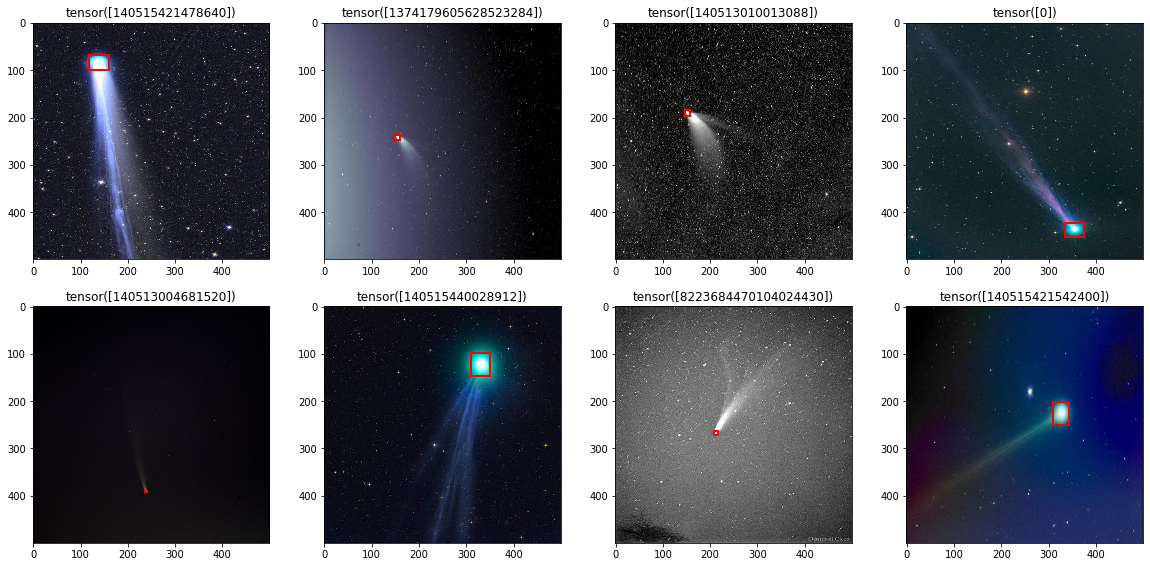

In [7]:
# check if all images and bounding in place
show_images_batch(next(iter(train_loader)))

# 2. Train model

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

100%|██████████| 500/500 [55:46<00:00,  6.69s/it]Train: loss = 21.211336087372345



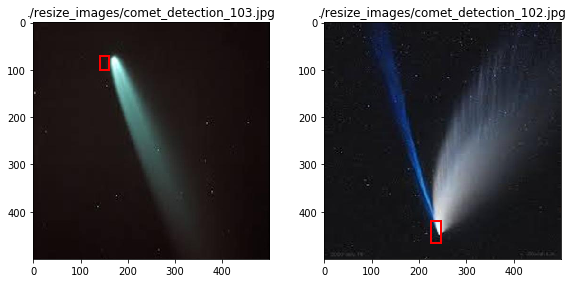

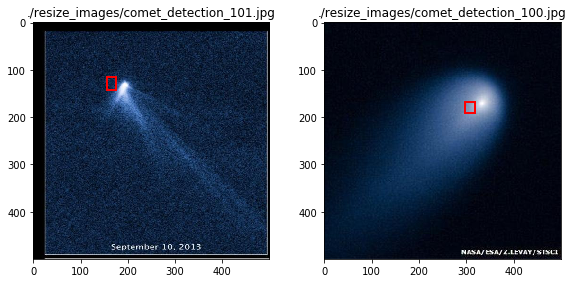

Test: loss function 31.978954315185547
CPU times: user 1h 26min 3s, sys: 2min 4s, total: 1h 28min 8s
Wall time: 55min 54s


In [9]:
%%time
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision.models import resnet18
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)

loss_function_x1y1 = torch.nn.L1Loss()
loss_function_x2y2 = torch.nn.L1Loss()
#loss_function_bce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

net = net.to(device)

n_epoch = 500
for epoch in tqdm(range(n_epoch),total=n_epoch):
    net.train()
    epoch_loss = 0.

    for batch in train_loader:
        images = batch['image']
        x1_y1 = batch['x1_y1']
        x2_y2 = batch['x2_y2']
        labels = batch['label']
        images = images.to(device,dtype=torch.float)
        x1_y1 = x1_y1.to(device)
        x2_y2 = x2_y2.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = net(images)

        loss = (loss_function_x1y1(predictions[:, :2], x1_y1) + \
               loss_function_x2y2(predictions[:, 2:4], x2_y2))
               # + loss_function_bce(predictions[:, :10], labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    clear_output(wait=True)
    print(f'Train: loss = {epoch_loss / len(train_loader)}')

torch.save(net, 'comet_detection_resnet_18')

net.eval()
epoch_loss = 0.
for batch in test_loader:
    # batch data to cuda
    images = batch['image']
    x1_y1 = batch['x1_y1']
    x2_y2 = batch['x2_y2']
    labels = batch['label']
    files_name = batch['file_name']
    
    images = images.to(device,dtype=torch.float)
    x1_y1 = x1_y1.to(device)
    x2_y2 = x2_y2.to(device)
    labels = labels.to(device)

    
    predictions = net(images)
    
    x1_y1_pred = predictions[:, :2]
    x2_y2_pred = predictions[:, 2:4]
    # calc loss
    with torch.no_grad():
        loss = (loss_function_x1y1(x1_y1_pred, x1_y1) + \
               loss_function_x2y2(x2_y2_pred, x2_y2))
                #+ loss_function_bce(predictions[:, :10], labels)
    epoch_loss += loss.item()
    # show detect bounding box
    show_list_images(batch['image'], x1_y1_pred, x2_y2_pred, labels, files_name)

print(f'Test: loss function {epoch_loss / len(test_loader)}')

In [10]:
def get_commet_detection(path_to_image, path_to_model):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import patches
    import torch
    from torchvision.transforms import ToTensor
    from PIL import Image
    
    pil_img = Image.open(path_to_image).convert('RGB')
    img_resize = pil_img.resize((500,500))
    #np_arr = np.moveaxis(np.asarray(pil_img),0, 2)
    fig, ax = plt.subplots(figsize = (10,10))
    ax.imshow(img_resize)

    image = ToTensor()(np.array(img_resize))
    image = image.unsqueeze(0)

    model = torch.load(path_to_model).to(device='cpu')
    model.eval()

    predictions = net.to(device='cpu')(image)
    
    with torch.no_grad():
        x1_y1 = predictions[:, :2]
        x2_y2 = predictions[:, 2:4]
        
        w = abs(x1_y1[0][0] - x2_y2[0][0])
        h = abs(x1_y1[0][1] - x2_y2[0][1])
        x = min(x1_y1[0][0],x2_y2[0][0])
        y = min(x1_y1[0][1],x2_y2[0][1])
    
    ax.add_patch(patches.Rectangle((x,y),w,h,
                                   fill=False, edgecolor='red', lw=2))
           
    plt.show()    

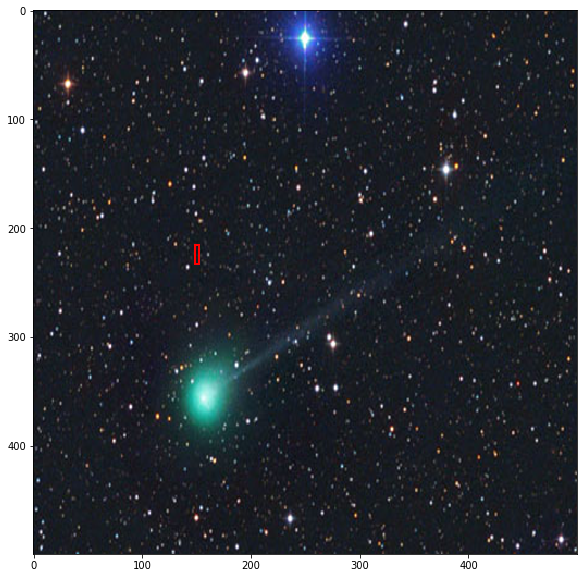

In [11]:
get_commet_detection('./S3-Panstarrs-July-15-Michael-Jaeger-STv1.jpg', './comet_detection_resnet_18')